History: created on 21/11/2020. Last modif: ... on 21/11/2020. Up to Date(21/11/2020)

In [1]:
%matplotlib inline
import cartopy.feature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import glac_mw.plotting as plotting
import glac_mw.saving as saving
import glac_mw.routing as routing
import glac_mw.spreading as spreading
import glac_mw.plotting as plotting
import glac_mw.glac1d_toolbox as tb
import datetime

# Sea level rise demo

Small demo to keep the sea level rise calculation. **To do**: To pylaeclim_leeds or glac_mw?

## Meltwater discharge

In [7]:
ds_wfix = xr.open_dataset("/nfs/annie/earpal/database/experiments/temev/inidata/temev.qrparm.waterfix.nc").isel(t=0).isel(depth=0)
ds_wfix

FileNotFoundError: [Errno 2] No such file or directory: b'/nfs/annie/eeymr/work/outputs/glac_mw/xosf/temev.qrparm.waterfix.nc'

In [4]:
ds_wfix_patch = xr.open_dataset("/nfs/annie/eeymr/work/outputs/glac_mw/xoup/xoupa.wfix.patch.nc").isel(t=0).isel(depth=0)
ds_wfix_patch

<xarray.Dataset>
Dimensions:    (latitude: 144, longitude: 290)
Coordinates:
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 358.75 360.0 361.25
  * latitude   (latitude) float32 -89.375 -88.125 -86.875 ... 88.125 89.375
    depth      float32 5.0
    t          object 1800-12-01 00:00:00
Data variables:
    field672   (latitude, longitude) float32 ...
Attributes:
    history:  Created on 2020-11-17 14:52:06.590744 by Yvan Romé
    title:    Waterfix for HadCM3 simulations [GLAC-1D] - Corrected using xou...

In [8]:
ds_discharge = xr.open_dataset("/nfs/annie/eeymr/work/outputs/glac_mw/xosf/temev.discharge.glac_mw.nc", decode_times=False)
ds_discharge

<xarray.Dataset>
Dimensions:    (latitude: 144, longitude: 288, t: 211)
Coordinates:
  * t          (t) int64 -21000 -20900 -20800 -20700 -20600 ... -300 -200 -100 0
  * latitude   (latitude) float32 -89.375 -88.125 -86.875 ... 88.125 89.375
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 356.25 357.5 358.75
Data variables:
    discharge  (t, latitude, longitude) float64 ...
Attributes:
    title:        Meltwater discharge for transient GLAC1D last delgaciation ...
    start_year:   -21
    end_year:     0
    step:         100
    mode:         spreaded
    mode_smooth:  diff
    lsm:          temev
    history:      Created 2020-06-11 20:45:24.325024 by Yvan Romé

In [9]:
surface = tb.surface_matrix(ds_discharge.longitude,ds_discharge.latitude)
surface_total = np.nansum(surface)
surface_total*10**-12 # km**2

510.06447190978827

In [10]:
wfix = np.nansum(ds_wfix.field672.values[:,:-2]*surface*10**-9)
wfix_patch = np.nansum(ds_wfix_patch.field672.values[:,:-2]*surface*10**-9)
discharge = np.nansum(((ds_discharge.discharge.values - ds_wfix.field672.values[:,:-2])*surface*10**-9),axis=(1,2))

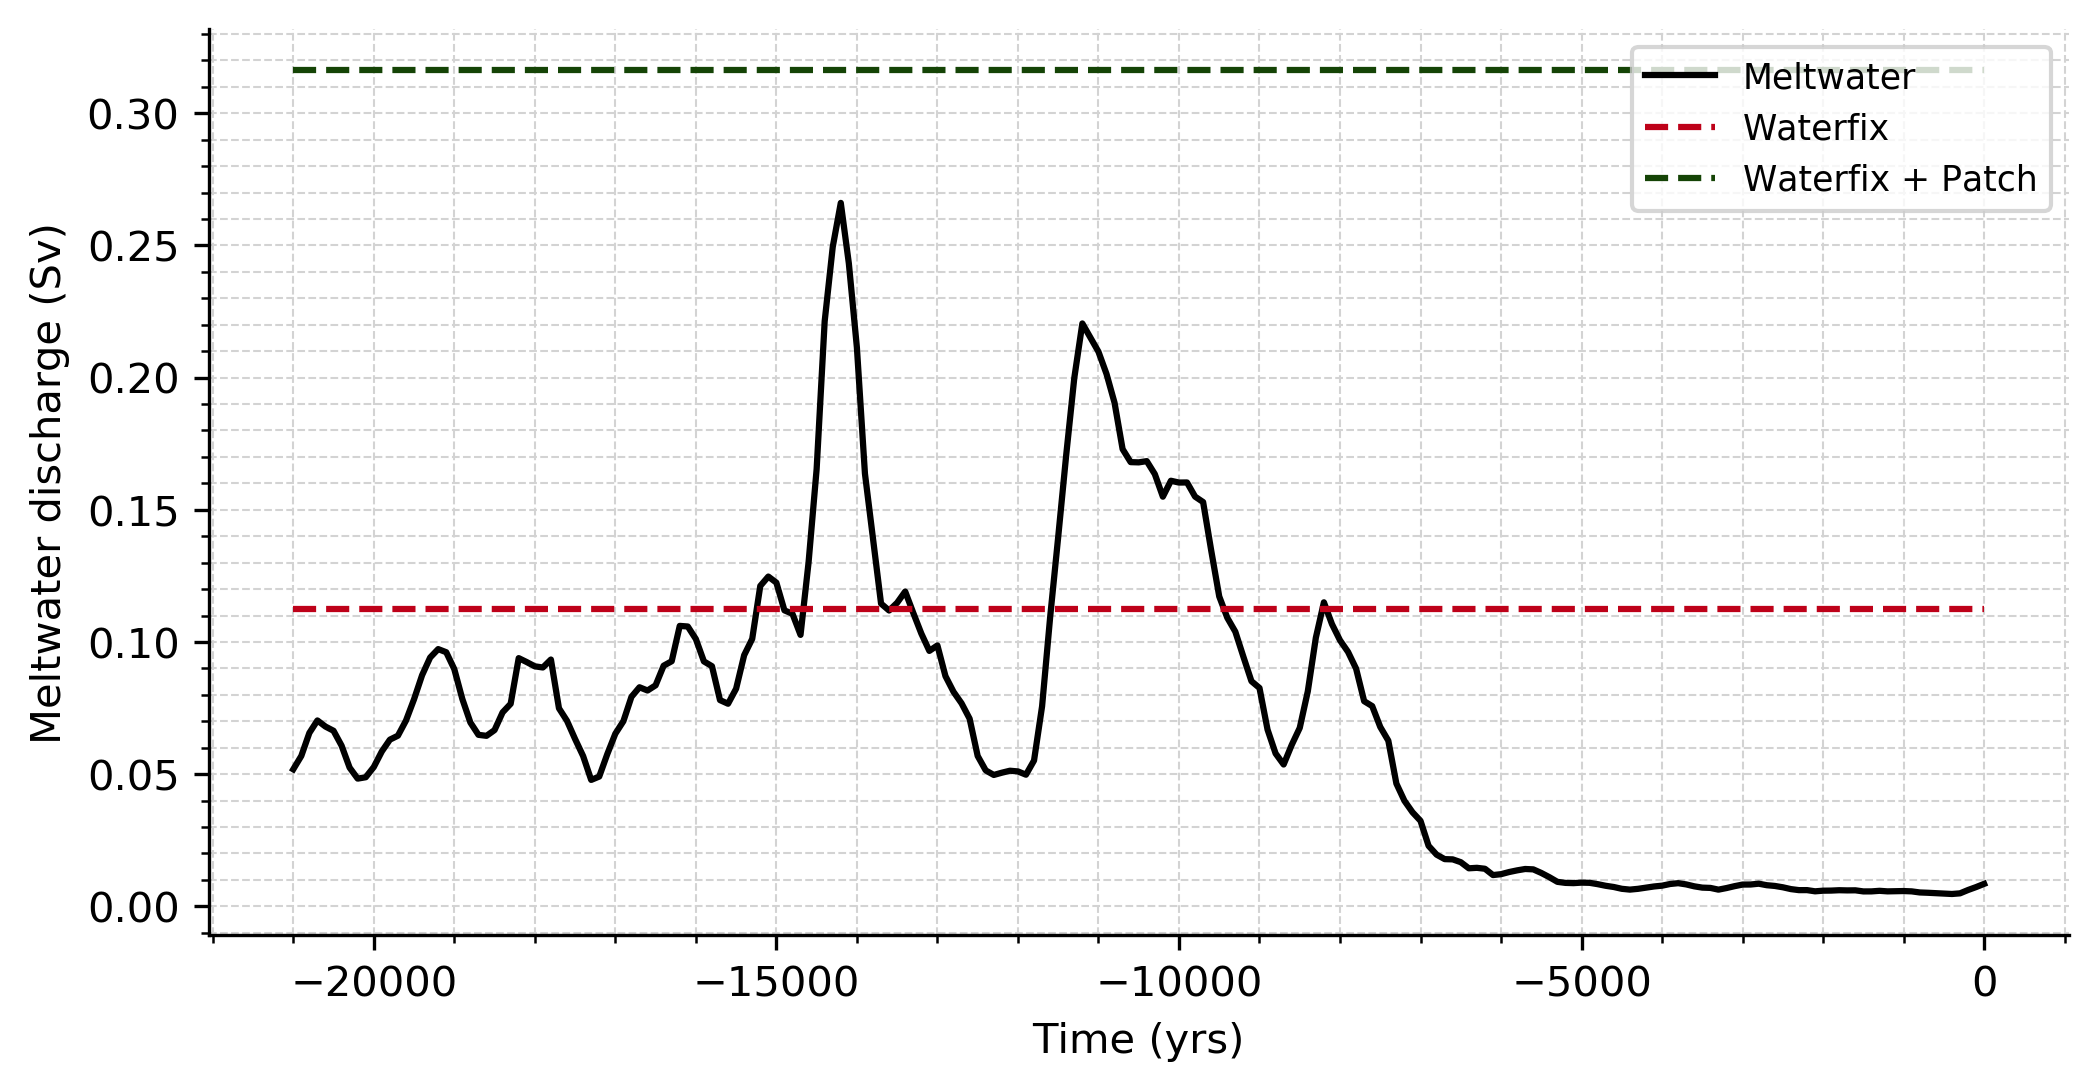

In [11]:
figMap, axMw = plt.subplots(nrows=1, ncols=1, figsize=(8,4), dpi=300)

axMw.plot(ds_discharge.t, tb.running_mean(discharge,5), label="Meltwater", color="xkcd:black", linestyle="-")
axMw.plot(ds_discharge.t, [wfix]*(len(ds_discharge.t)), label="Waterfix", color="xkcd:scarlet", linestyle="--")
axMw.plot(ds_discharge.t, [wfix_patch]*(len(ds_discharge.t)), label="Waterfix + Patch", color="xkcd:forrest green", linestyle="--")

axMw.legend(loc="upper right", fontsize='small')
axMw.spines['right'].set_visible(False)
axMw.spines['top'].set_visible(False)
axMw.set_xlabel("Time (yrs)")
axMw.set_ylabel("Meltwater discharge (Sv)")
axMw.minorticks_on()
axMw.grid(which = "both", color='lightgrey', linestyle='--', linewidth=0.5)

## Sea level rise

In [14]:
def calculate_slr(discharge, lon, lat, time, wfix=None):

    delta_t = (time[1] - time[0])*3600*24*360
    ro = 1000
        
    lsm = discharge[0]/discharge[0]
    surface_matrix = tb.surface_matrix(lon,lat) * lsm
    surface_total = np.nansum(surface_matrix)
    
    slr_t = np.zeros(len(time))
    slr_c = np.zeros(len(time))

    for t in range(discharge.shape[0]):
        if wfix is not None:
            slr_t[t] = np.nansum(delta_t * (discharge[t] - wfix)*surface_matrix/surface_total/ro)
            slr_c[t] = np.sum(slr_t)
        else:
            slr_t[t] = np.nansum(delta_t * (discharge[t])*surface_matrix/surface_total/ro)
            slr_c[t] = np.sum(slr_t)
    
    return slr_t, slr_c

In [23]:
lon, lat, t = ds_discharge.longitude.values, ds_discharge.latitude.values, ds_discharge.t.values
wfix = ds_wfix.field672.values[:,:-2]
wfix_values = np.resize(wfix, (len(t), wfix.shape[0], wfix.shape[1]))
wfix_patch_values = np.resize(ds_wfix_patch.field672.values[:,:-2], (len(t), wfix.shape[0], wfix.shape[1]))

slr_t, slr_c = calculate_slr(ds_discharge.discharge.values, lon, lat, t, wfix = wfix)
slr_wfix, slr_wfix_c = calculate_slr(wfix_values, lon, lat, t)
slr_wfix_patch, slr_wfix_patch_c = calculate_slr(wfix_patch_values, lon, lat, t)

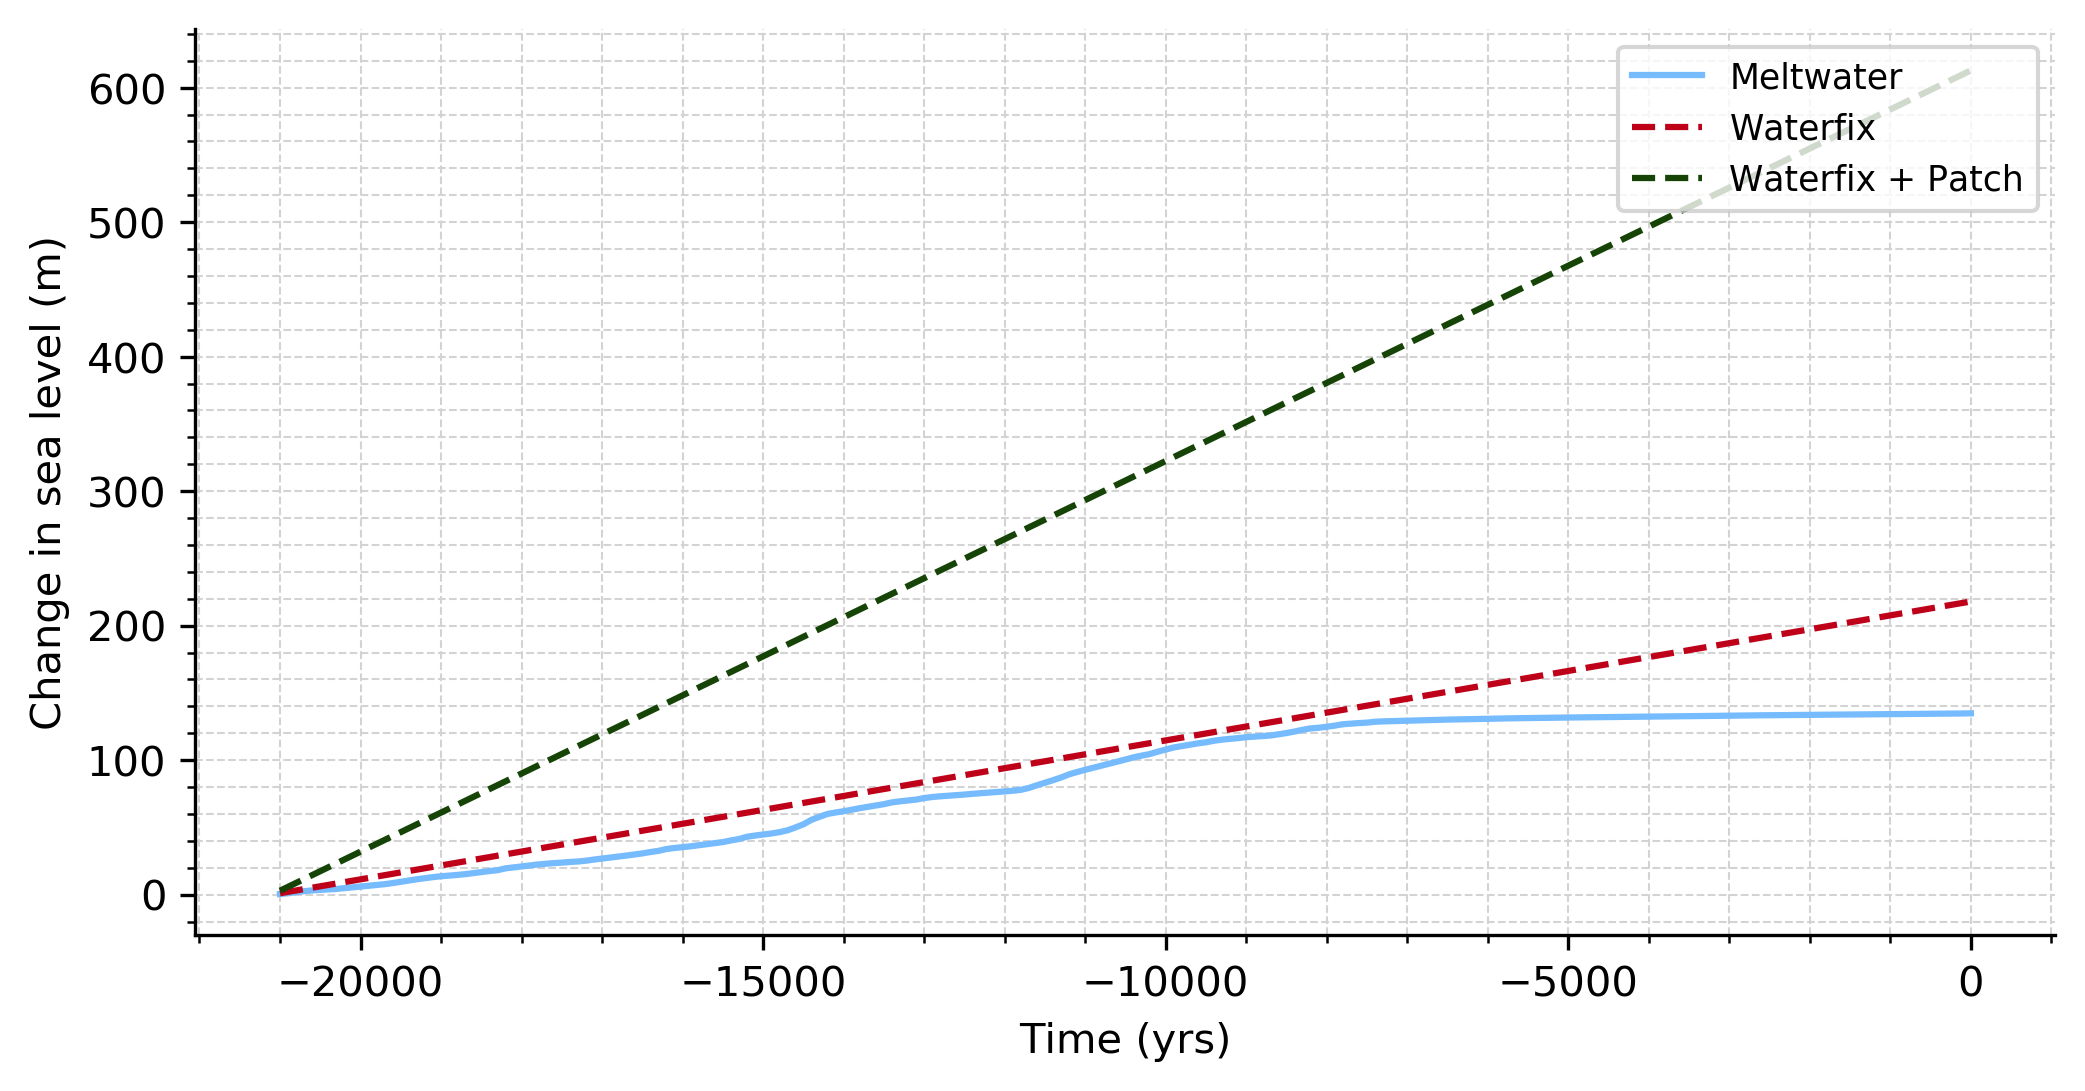

In [24]:
figMap, axMw = plt.subplots(nrows=1, ncols=1, figsize=(8,4), dpi=300)

axMw.plot(ds_discharge.t, slr_c, label="Meltwater", color="xkcd:sky blue", linestyle="-")
axMw.plot(ds_discharge.t, slr_wfix_c, label="Waterfix", color="xkcd:scarlet", linestyle="--")
axMw.plot(ds_discharge.t, slr_wfix_patch_c, label="Waterfix + Patch", color="xkcd:forrest green", linestyle="--")

axMw.legend(loc="upper right", fontsize='small')
axMw.spines['right'].set_visible(False)
axMw.spines['top'].set_visible(False)
axMw.set_xlabel("Time (yrs)")
axMw.set_ylabel("Change in sea level (m)")
axMw.minorticks_on()
axMw.grid(which = "both", color='lightgrey', linestyle='--', linewidth=0.5)